# Import Libraries

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline
import pandas as pd 
from tabulate import tabulate
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [2]:
train1 = pd.read_csv('train_month_3_with_target.csv')
train2 = pd.read_csv('train_month_2.csv')
train3 = pd.read_csv('train_month_1.csv')
test1 = pd.read_csv('test_month_3.csv')
test2 = pd.read_csv('test_month_2.csv')
test3 = pd.read_csv('test_month_1.csv')

# Data pre-processing

## Dataset info

In [3]:
#train1.info()
train1.describe()
train1.isna().any()
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63697 entries, 0 to 63696
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   client_id                          63697 non-null  object 
 1   homebanking_active                 63697 non-null  int64  
 2   has_homebanking                    63697 non-null  int64  
 3   has_insurance_21                   63697 non-null  int64  
 4   has_insurance_23                   63697 non-null  int64  
 5   has_life_insurance_fixed_cap       63697 non-null  int64  
 6   has_life_insurance_decreasing_cap  63697 non-null  int64  
 7   has_fire_car_other_insurance       63697 non-null  int64  
 8   has_personal_loan                  63697 non-null  int64  
 9   has_mortgage_loan                  63697 non-null  int64  
 10  has_current_account                63697 non-null  int64  
 11  has_pension_saving                 63697 non-null  int

In [4]:
train1['customer_since_all'] = pd.to_datetime(train1['customer_since_all'])
train1['customer_since_bank'] = pd.to_datetime(train1['customer_since_bank'])
train1['customer_birth_date'] = pd.to_datetime(train1['customer_birth_date'])

cat_vars = []
cont_vars = []
columns = list(train1.drop(columns = ['client_id']).columns)
for i in columns:
    if (len(train1.loc[:,i].unique()) >= 20):
        cont_vars.append(i)
    else:
        cat_vars.append(i)
        
print('Continious variables are:',cont_vars)
print('------------------')
print('Categorical variables are:',cat_vars)
# Here we have our list of categorical and continious variables

Continious variables are: ['bal_insurance_21', 'bal_insurance_23', 'cap_life_insurance_fixed_cap', 'cap_life_insurance_decreasing_cap', 'prem_fire_car_other_insurance', 'bal_personal_loan', 'bal_mortgage_loan', 'bal_current_account', 'bal_pension_saving', 'bal_savings_account', 'bal_savings_account_starter', 'bal_current_account_starter', 'customer_since_all', 'customer_since_bank', 'customer_birth_date', 'customer_postal_code']
------------------
Categorical variables are: ['homebanking_active', 'has_homebanking', 'has_insurance_21', 'has_insurance_23', 'has_life_insurance_fixed_cap', 'has_life_insurance_decreasing_cap', 'has_fire_car_other_insurance', 'has_personal_loan', 'has_mortgage_loan', 'has_current_account', 'has_pension_saving', 'has_savings_account', 'has_savings_account_starter', 'has_current_account_starter', 'visits_distinct_so', 'visits_distinct_so_areas', 'customer_gender', 'customer_occupation_code', 'customer_self_employed', 'customer_education', 'customer_children', 

### Categorical features unique values

In [5]:
# To check we will print all unique values
for col in cat_vars:
    print(col,train1[col].unique())

homebanking_active [0 1]
has_homebanking [0 1]
has_insurance_21 [0 1]
has_insurance_23 [0 1]
has_life_insurance_fixed_cap [0 1]
has_life_insurance_decreasing_cap [0 1]
has_fire_car_other_insurance [1 0]
has_personal_loan [0 1]
has_mortgage_loan [0 1]
has_current_account [1 0]
has_pension_saving [0 1]
has_savings_account [1 0]
has_savings_account_starter [0 1]
has_current_account_starter [0 1]
visits_distinct_so [1. 2. 3. 4. 6. 5. 7.]
visits_distinct_so_areas [1. 2. 3. 5. 4. 6.]
customer_gender [1 2]
customer_occupation_code [ 9. nan  7.  8.  4.  5.  0.  6.  3.  1.  2.]
customer_self_employed [0 1]
customer_education [ 0. nan  2.  1.  4.  3.  5.  6.]
customer_children [nan 'mature' 'no' 'young' 'preschool' 'adolescent' 'grownup' 'onebaby'
 'yes']
customer_relationship [nan 'couple' 'single']
target [0 1]


### Colums with missing Data

In [6]:
missing_df = train1.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['%']=(missing_df['missing values'])/train1.shape[0]*100
missing_df = missing_df[missing_df['missing values'] >0].sort_values('%')
missing_df

,variable,missing values,%
29,customer_since_all,234,0.367364
30,customer_since_bank,249,0.390913
34,customer_occupation_code,2002,3.143005
38,customer_relationship,14899,23.390427
37,customer_children,23364,36.679906
36,customer_education,47125,73.983076


In [47]:
missing_df = train2.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['%']=(missing_df['missing values'])/train1.shape[0]*100
missing_df = missing_df[missing_df['missing values'] >0].sort_values('%')
missing_df

,variable,missing values,%
29,customer_since_all,234,0.367364
30,customer_since_bank,249,0.390913
34,customer_occupation_code,2002,3.143005
38,customer_relationship,14476,22.726345
37,customer_children,23065,36.210497
36,customer_education,47125,73.983076


In [48]:
missing_df = train3.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['%']=(missing_df['missing values'])/train1.shape[0]*100
missing_df = missing_df[missing_df['missing values'] >0].sort_values('%')
missing_df

,variable,missing values,%
29,customer_since_all,234,0.367364
30,customer_since_bank,249,0.390913
34,customer_occupation_code,2002,3.143005
38,customer_relationship,14456,22.694946
37,customer_children,23056,36.196367
36,customer_education,47125,73.983076


In [49]:
print(train2.loc[train1['customer_since_bank'].isna(),'customer_since_bank'].value_counts().sum())
print(train3.loc[train1['customer_since_bank'].isna(),'customer_since_bank'].value_counts().sum())
print(train3.loc[train2['customer_relationship'].isna(),'customer_relationship'].value_counts().sum())

print(train2.loc[train1['customer_relationship'].isna(),'customer_relationship'].unique())

0
0
21
[nan 'couple' 'single']


## Missing value exploration

In [10]:
missing_df2 = missing_df[missing_df['missing values'] >250]
for col in missing_df2['variable']:
    print(col,train1[col].unique())

customer_occupation_code [ 9. nan  7.  8.  4.  5.  0.  6.  3.  1.  2.]
customer_relationship [nan 'couple' 'single']
customer_children [nan 'mature' 'no' 'young' 'preschool' 'adolescent' 'grownup' 'onebaby'
 'yes']
customer_education [ 0. nan  2.  1.  4.  3.  5.  6.]


<AxesSubplot:xlabel='customer_education', ylabel='count'>

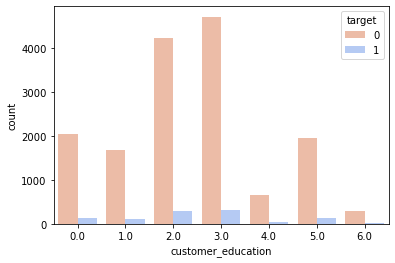

In [11]:
sns.countplot(x='customer_education',data=train1,hue='target',palette="coolwarm_r")

job_code 0 421
job_code 1 24
job_code 2 7
job_code 3 10
job_code 4 1639
job_code 5 153
job_code 6 183
job_code 7 104
job_code 8 318
job_code 9 58836


<AxesSubplot:xlabel='customer_occupation_code', ylabel='Count'>

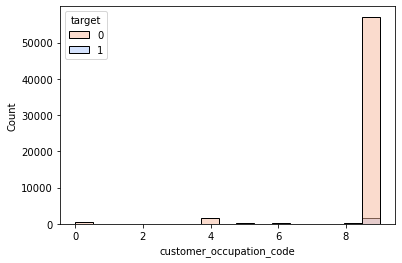

In [16]:
for x in range(0,10):
    print(f'job_code {x}', len(train1.loc[(train1['customer_occupation_code']==x)]))
    
sns.histplot(x='customer_occupation_code',data=train1,hue='target',palette="coolwarm_r")

<AxesSubplot:xlabel='customer_occupation_code', ylabel='Count'>

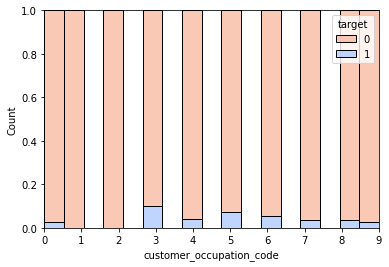

In [15]:
sns.histplot(x='customer_occupation_code',data=train1,hue='target',palette="coolwarm_r",multiple = "fill")

In [18]:


a = len(train1.loc[(train1['customer_relationship']=='couple') & (train1['target']== 0)])+len(train1.loc[(train1['customer_relationship']=='couple') & (train1['target']== 1)]) 

b = len(train1.loc[(train1['customer_relationship']=='single') & (train1['target']== 0)])+ len(train1.loc[(train1['customer_relationship']=='single') & (train1['target']== 1)]) 
table=[['Relationship','0','1'],
        [str(len(train1.loc[(train1['customer_relationship']=='couple')])) + ' Couple',round(len(train1.loc[(train1['customer_relationship']=='couple') & (train1['target']== 0)])/a,3 ),round(len(train1.loc[(train1['customer_relationship']=='couple') & (train1['target']== 1)])/a,3) ],
        [str(len(train1.loc[(train1['customer_relationship']=='single')])) + ' Single',round(len(train1.loc[(train1['customer_relationship']=='single') & (train1['target']== 0)])/b,3) ,round(len(train1.loc[(train1['customer_relationship']=='single') & (train1['target']== 1)])/b,3) ]]
print(tabulate(table, headers='firstrow'))



Relationship        0      1
--------------  -----  -----
36179 Couple    0.969  0.031
12619 Single    0.974  0.026


In [19]:
rep = {'mature':1,'no':0, 'young':1,'preschool':1,'adolescent':1,'grownup':1,'onebaby':1
 ,'yes':1}
train1['customer_children']= train1['customer_children'].replace(rep) 

In [20]:
c = len(train1.loc[(train1['customer_children']==0) & (train1['target']== 0)])+len(train1.loc[(train1['customer_children']==0) & (train1['target']== 1)]) 

d = len(train1.loc[(train1['customer_children']==1) & (train1['target']== 0)])+ len(train1.loc[(train1['customer_children']==1) & (train1['target']== 1)]) 
table=[['Children','0','1'],
        [str(len(train1.loc[(train1['customer_children']==0)])) + ' Without kids',round(len(train1.loc[(train1['customer_children']==0) & (train1['target']== 0)])/c,2 ),round(len(train1.loc[(train1['customer_children']==0) & (train1['target']== 1)])/c,2) ],
        [str(len(train1.loc[(train1['customer_children']==1)])) + ' With kids',round(len(train1.loc[(train1['customer_children']==1) & (train1['target']== 0)])/d,2) ,round(len(train1.loc[(train1['customer_children']==1) & (train1['target']== 1)])/d,2) ]]
print(tabulate(table, headers='firstrow'))

Children               0     1
------------------  ----  ----
22886 Without kids  0.98  0.02
17447 With kids     0.96  0.04


<AxesSubplot:xlabel='customer_children', ylabel='Count'>

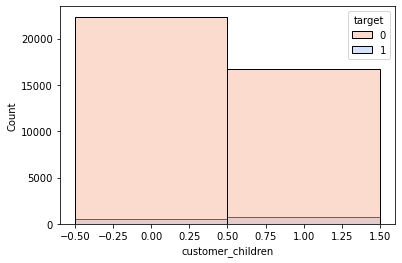

In [23]:
train1['customer_children'] = pd.Categorical(train1['customer_children'])
sns.histplot(x='customer_children',data=train1,hue='target',palette="coolwarm_r")

[(0.0, 0.06)]

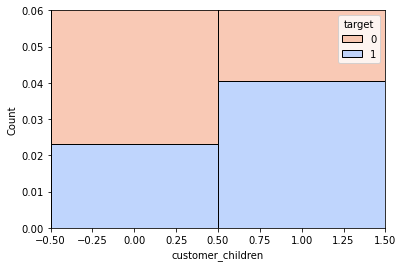

In [26]:
plot = sns.histplot(x='customer_children',data=train1,hue='target',palette="coolwarm_r",multiple = "fill")
plot.set(ylim=(0,0.06))

In [27]:
# thjis var seems useful what do we do about missing values

In [38]:
train1_test = train1.copy()
# train1_test['customer_children'].isna()
train1_test['customer_children'] = pd.to_numeric(train1_test['customer_children'])
train1_test.loc[train1_test['customer_children'].isna(),'customer_children'] = 2

In [41]:
train1_test['customer_children'].replace({0:'no children',1:'children',2:'missing'})
train1_test['customer_children'] = pd.Categorical(train1_test['customer_children'])

[(0.0, 0.06)]

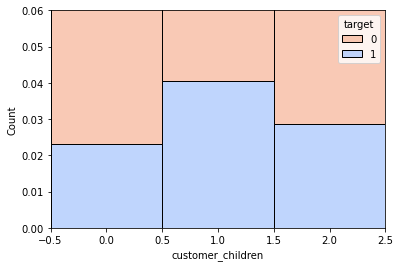

In [42]:
plot = sns.histplot(x='customer_children',data=train1_test,hue='target',palette="coolwarm_r",multiple = "fill")
plot.set(ylim=(0,0.06))

## Remove columns and transform date columns

In [ ]:
df_list=[train1,train2,train3,test1,test2,test3]

In [ ]:
def drop_col(x):
    x.drop(['customer_children','customer_relationship','customer_occupation_code',
            'customer_education',],axis=1, inplace=True) 
    x.dropna(axis=0, inplace=True) 

In [ ]:
def striptime(x):
    x['customer_since_all'] = pd.to_datetime(x['customer_since_all'])
    x['customer_since_bank'] = pd.to_datetime(x['customer_since_bank'])
    x['customer_birth_date'] = pd.to_datetime(x['customer_birth_date'])
    x['Birth_year'] = x['customer_birth_date'].dt.strftime('%Y').astype(str).astype(int)
    x['Year_since_all'] = x['customer_since_all'].dt.strftime('%Y').astype(str).astype(int)
    x['Month_since_all'] = x['customer_since_all'].dt.strftime('%m').astype(str).astype(int)
    x['Year_since_bank'] = x['customer_since_bank'].dt.strftime('%Y').astype(str).astype(int)
    x['Month_since_bank'] = x['customer_since_bank'].dt.strftime('%m').astype(str).astype(int)
    x.drop(['customer_since_all','customer_since_bank','customer_birth_date'], axis=1, inplace=True)

In [ ]:
for x in df_list:
    drop_col(x)
    striptime(x)
    print(x.shape)

## Removing outliers

We have noticed some of the clients are born in the 80s. Therefore we will assign a threshhold of 100years for the client's age.  In addition, the client's birth year cannot greater than the year he started using the banks services.

In [ ]:
def remove_out(x):
    x.drop(x[x['Birth_year'] < 1919].index, inplace = True)
    x.drop(x.loc[x['Birth_year'] > (x['Year_since_all'] | x['Year_since_bank'])].index, inplace=True)

remove_out(train1)
remove_out(train2)
remove_out(train3)
remove_out(test1)
remove_out(test2)
remove_out(test3)

## Feature Engineering

First, let's extract the customer's Age and drop Birth_year

In [ ]:
def client_age(x):
    x['Age'] = x['Birth_year'].apply(lambda x: 2018 -x)
    x.drop('Birth_year', axis=1, inplace=True)
    
for x in df_list:
    client_age(x)

- We could see if there is a significant (large) difference in say balance or savings as this could be an indicator that the client is about to churn. (can just be stored as a boolean). 
- can also compute a boolean regarding the change in some services that the client has. Say he dropped in insurrance 21 last month or smtg. also as a boolean 

In [ ]:
#creates a new column in the dataset with a boolean regarding if the values between the 3 columns are the same. 

def change(orig1,orig2,orig3, cols_bool,cols_cont,key ='client_id'):
    columns= [key] + cols_bool + cols_cont
    merged_1 = pd.merge(orig1,orig2[columns], how = 'left',on = key, suffixes=['','-1'])
    merged = pd.merge(merged_1,orig3[columns], how = 'left',on = key, suffixes=['','-2'])
    to_drop =[]
    for var in cols_bool:
        merged['ch_{}'.format(var)] = np.where((merged[var]==merged['{}-1'.format(var)])&(
                                   merged[var] == merged['{}-2'.format(var)]),0,1)
        merged['ch_{}'.format(var)] = pd.Categorical(merged['ch_{}'.format(var)])
        merged[var] = pd.Categorical(merged[var])
        to_drop+=['{}-1'.format(var),'{}-2'.format(var)]
    for var in cols_cont:
        merged['diff_mth1_{}'.format(var)] = -merged[var]+merged['{}-1'.format(var)]
        merged['diff_mth2_{}'.format(var)] = -merged[var]+merged['{}-2'.format(var)]  
        to_drop+=['{}-1'.format(var),'{}-2'.format(var)]
    merged.drop(to_drop,axis=1,inplace=True)
    return merged

In [ ]:
# create a new column regarding if there was a change in any var that starts w has_... in the last couple months
# will be 1 if there was any change in the last 2 months 0 otherwise
to_bool = ['homebanking_active', 'has_homebanking',
       'has_insurance_21', 'has_insurance_23', 'has_life_insurance_fixed_cap',
       'has_life_insurance_decreasing_cap', 'has_fire_car_other_insurance',
       'has_personal_loan', 'has_mortgage_loan', 'has_current_account',
       'has_pension_saving', 'has_savings_account',
       'has_savings_account_starter', 'has_current_account_starter']
to_diff_cont = ['bal_insurance_21', 'bal_insurance_23','bal_personal_loan', 
        'bal_mortgage_loan', 'bal_current_account',
        'bal_pension_saving', 'bal_savings_account',
        'bal_savings_account_starter', 'bal_current_account_starter',
        'cap_life_insurance_fixed_cap','cap_life_insurance_decreasing_cap']
train_s = change(train1,train2,train3, to_bool,to_diff_cont)
train_s.columns

## Feature selection

### Categorical vars

In [ ]:
cat_variables = ['homebanking_active', 'has_homebanking',
       'has_insurance_21', 'has_insurance_23', 'has_life_insurance_fixed_cap',
       'has_life_insurance_decreasing_cap', 'has_fire_car_other_insurance',
       'has_personal_loan', 'has_mortgage_loan', 'has_current_account',
       'has_pension_saving', 'has_savings_account',
       'has_savings_account_starter', 'has_current_account_starter','visits_distinct_so', 'visits_distinct_so_areas', 'customer_gender',
       'customer_self_employed','ch_homebanking_active',
       'ch_has_homebanking', 'ch_has_insurance_21', 'ch_has_insurance_23',
       'ch_has_life_insurance_fixed_cap',
       'ch_has_life_insurance_decreasing_cap',
       'ch_has_fire_car_other_insurance', 'ch_has_personal_loan',
       'ch_has_mortgage_loan', 'ch_has_current_account',
       'ch_has_pension_saving', 'ch_has_savings_account',
       'ch_has_savings_account_starter', 'ch_has_current_account_starter']
for var in cat_variables:
    train_s[var] = pd.Categorical(train_s[var]) 

In [ ]:
sns.set(rc={'figure.figsize':(5,3)}) 
fig, axes = plt.subplots(11, 3, figsize=(100, 60))

i = 0
j = 0
for variable in cat_variables:
    sns.histplot(ax=axes[i, j],data=train_s, x=variable, hue = "target" , multiple="stack",hue_order = [0,1])
    j = j + 1
    if (j > 2):
        j = 0
        i = i + 1

In [ ]:
fig, axes = plt.subplots(11, 3, figsize=(100, 60))

i = 0
j = 0
for variable in cat_variables:
    sns.histplot(ax=axes[i, j],data=train_s, x=variable, hue = "target" , multiple="fill",hue_order = [0,1])
    j = j + 1
    if (j > 2):
        j = 0
        i = i + 1

In [ ]:
sns.set(rc={'figure.figsize':(5,3)}) 
fig, axes = plt.subplots(11, 3, figsize=(100, 60))

i = 0
j = 0
for variable in cat_variables:
    plot = sns.histplot(ax=axes[i, j],data=train_s, x=variable, hue = "target" , multiple="fill",hue_order = [0,1])
    plot.set(ylim=(0, 0.06))
    j = j + 1
    if (j > 2):
        j = 0
        i = i + 1

In [ ]:
vars_to_explore = ['has_insurance_23','has_insurance_21','has_fire_car_other_insurance',
                   'ch_has_insurance_21','ch_has_savings_account','ch_has_current_account',
                   'ch_homebanking_active','has_pension_saving','has_life_insurance_fixed_cap',
                   'customer_postal_code','has_current_account_starter','ch_has_current_account_starter',
                   'has_savings_account_starter','visits_distinct_so_areas','ch_has_life_insurance_decreasing_cap',
                   'ch_has_mortgage_loan','ch_has_savings_account_starter','ch_has_fire_car_other_insurance',
                   'ch_has_insurance_23','visits_distinct_so','ch_has_homebanking','ch_has_personal_loan',
                   'ch_has_pension_saving','ch_has_current_account_starter']

In [ ]:
from scipy.stats import chi2_contingency 
from scipy.stats import chi2

In [ ]:
remove = []
keep = []
for x in vars_to_explore:
    test = pd.crosstab(train_s['target'],train_s[x],margins = False)
    stat, p, dof, expected = chi2_contingency(test)
    critical = chi2.ppf(0.99, dof)
    if abs(stat) >= critical:
        keep = keep + [x]
        print(x + ': Dependent (reject H0)')
    else:
        remove = remove + [x]
        print(x + ': Independent (fail to reject H0)')

In [ ]:
print(keep)

### Continious vars

In [ ]:
cont_vars = ['bal_insurance_21', 'bal_insurance_23','bal_personal_loan', 
'bal_mortgage_loan', 'bal_current_account',
'bal_pension_saving', 'bal_savings_account',
'bal_savings_account_starter', 'bal_current_account_starter',
'cap_life_insurance_fixed_cap','cap_life_insurance_decreasing_cap',
'diff_mth1_bal_insurance_21', 'diff_mth2_bal_insurance_21',
'diff_mth1_bal_insurance_23', 'diff_mth2_bal_insurance_23',
'diff_mth1_bal_personal_loan', 'diff_mth2_bal_personal_loan',
'diff_mth1_bal_mortgage_loan', 'diff_mth2_bal_mortgage_loan',
'diff_mth1_bal_current_account', 'diff_mth2_bal_current_account',
'diff_mth1_bal_pension_saving', 'diff_mth2_bal_pension_saving',
'diff_mth1_bal_savings_account', 'diff_mth2_bal_savings_account',
'diff_mth1_bal_savings_account_starter',
'diff_mth2_bal_savings_account_starter',
'diff_mth1_bal_current_account_starter',
'diff_mth2_bal_current_account_starter',
'diff_mth1_cap_life_insurance_fixed_cap',
'diff_mth2_cap_life_insurance_fixed_cap',
'diff_mth1_cap_life_insurance_decreasing_cap',
'diff_mth2_cap_life_insurance_decreasing_cap']

In [ ]:
sns.set(rc={'figure.figsize':(5,3)}) 
fig, axes = plt.subplots(11, 3, figsize=(100, 60))

i = 0
j = 0
for variable in cont_vars:
    sns.histplot(ax=axes[i, j],data=train_s, x=variable, hue = "target" , multiple="stack",hue_order = [0,1],
                bins = 50)
    j = j + 1
    if (j > 2):
        j = 0
        i = i + 1

In [ ]:
sns.set(rc={'figure.figsize':(5,3)}) 
fig, axes = plt.subplots(11, 3, figsize=(100, 60))

i = 0
j = 0
for variable in cont_vars:
    plot = sns.histplot(ax=axes[i, j],data=train_s, x=variable, hue = "target" , multiple="fill",hue_order = [0,1],
                        bins = 50)
    plot.set(ylim=(0, 0.06))
    j = j + 1
    if (j > 2):
        j = 0
        i = i + 1

In [ ]:
keep_cont = ['bal_savings_account',' diff_mth2_bal_savings_account','bal_current_account',
             'diff_mth1_bal_current_account','diff_mth1_bal_savings_account',' diff_mth2_bal_current_account']

In [ ]:
len(keep + keep_cont)

In [ ]:
## Dimension reductioin

In [ ]:
# #check if df is factorable 
# train_fa = train_s.drop(['client_id','target'],axis=1)
# chi_square_value,p_value=calculate_bartlett_sphericity(train_fa)
# chi_square_value, p_value

In [ ]:
# _,kmo_model=calculate_kmo(train_fa)

In [ ]:
# fa = FactorAnalyzer(n_factors=30,rotation=None )
# fa.fit(train_fa )
# # Check Eigenvalues
# ev, v = fa.get_eigenvalues()
# ev

In [ ]:
# # Create scree plot
# plt.scatter(range(1,train_fa.shape[1]+1),ev)
# plt.plot(range(1,train_fa.shape[1]+1),ev)
# plt.title('Scree Plot')
# plt.xlabel('Factors')
# plt.ylabel('Eigenvalue')
# plt.grid()
# plt.show()

In [ ]:
#  #Create factor analysis object and perform factor analysis
# fa = FactorAnalyzer(20, rotation="varimax")
# fa.fit(train_fa)

In [ ]:
# pd.DataFrame(fa.loadings_, index=train_fa.columns)

In [ ]:
# check variance explained 
pd.DataFrame(fa.get_factor_variance(), index=['SS Loadings','Proportion Var','Cumulative Var'])

# Modeling Creation

# Model Evaluation

# Model Improvement

# WISSAM